In [1]:
import pickle
import numpy as np
import pandas as pd
import scipy
import torch
import matplotlib.pyplot as plt
from gurobipy import GRB
from plots import *
from ems_data import *
from simulation import *
from neural_network import *
from mip_models import *

TRAINING_METRICS = ['coverage_9min', 'coverage_15min', 'survival_rate', 'response_time_mean', 'response_time_median', 'response_time_90th_percentile']
FACILITY_CAPACITY = 5
TIME_LIMIT = 60  # Set to 600 for final results
SUCCESS_PROB = 0.9

def plot_metric(X: np.ndarray, y: np.ndarray, metric: str):
    """Plot histogram and box plots side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].hist(y, bins=100)
    ax[0].set_xlabel(metric)
    ax[0].set_ylabel("Frequency")
    plot_metric_by_ambulance_count(X, y, metric, ax=ax[1])
    return fig, ax

def best_solution_from_dataset(dataset: pd.DataFrame, n_ambulances: int, metric: str) -> tuple[pd.Series, pd.Series]:
    """Finds the best solution w.r.t. a metric for a given maximum number of ambulances."""
    Y = dataset[METRICS]
    X = dataset.drop(columns=METRICS)
    indices = np.where(X.sum(axis=1) <= n_ambulances)[0]
    argmin_or_argmax = np.argmin if 'response_time' in metric else np.argmax
    y = Y[metric]
    best_idx = indices[argmin_or_argmax(y[indices])]
    return X.iloc[best_idx], Y.iloc[best_idx]

def remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='right'):
    """For each total number of ambulances, isolate samples with that total and remove outliers.

    Parameters
    ----------
    X, y : np.ndarray
        The dataset.
    
    percent : int, optional
        Percentage of data to remove.
    
    tail : {'left', 'right', 'both'}, optional
        Which tail to remove outliers from.

        For maximization problems, use 'left'. For minimization problems, use 'right'.

    Returns
    -------
    X_new, y_new : np.ndarray
        The dataset with outliers removed.
    """
    X_sum = X.sum(axis=1)
    min_ambulances = X_sum.min()
    max_ambulances = X_sum.max()
    keep = np.full(X.shape[0], False)
    for total in range(min_ambulances, max_ambulances+1):
        left_threshold = -np.inf
        right_threshold = np.inf
        if tail == 'right':
            right_threshold = np.percentile(y[X_sum == total], 100-percent)
        elif tail == 'left':
            left_threshold = np.percentile(y[X_sum == total], percent)
        elif tail == 'both':
            left_threshold = np.percentile(y[X_sum == total], percent/2)
            right_threshold = np.percentile(y[X_sum == total], 1 - percent/2)
        keep |= (X_sum == total) & (left_threshold < y) & (y < right_threshold)
    return X[keep], y[keep]

def rescale(x: np.ndarray, min: float = 0, max: float = 1) -> np.ndarray:
    """Shift and scale data to the range [min, max]."""
    return (x - x.min()) / (x.max() - x.min()) * (max - min) + min

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

# stations: 20
# demand nodes: 848


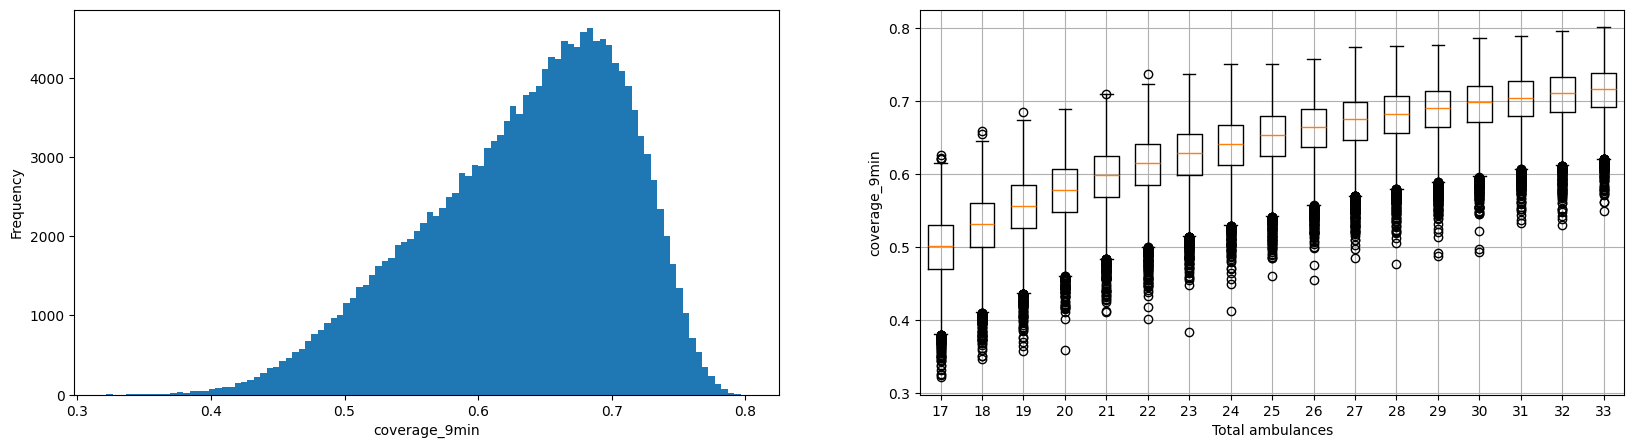

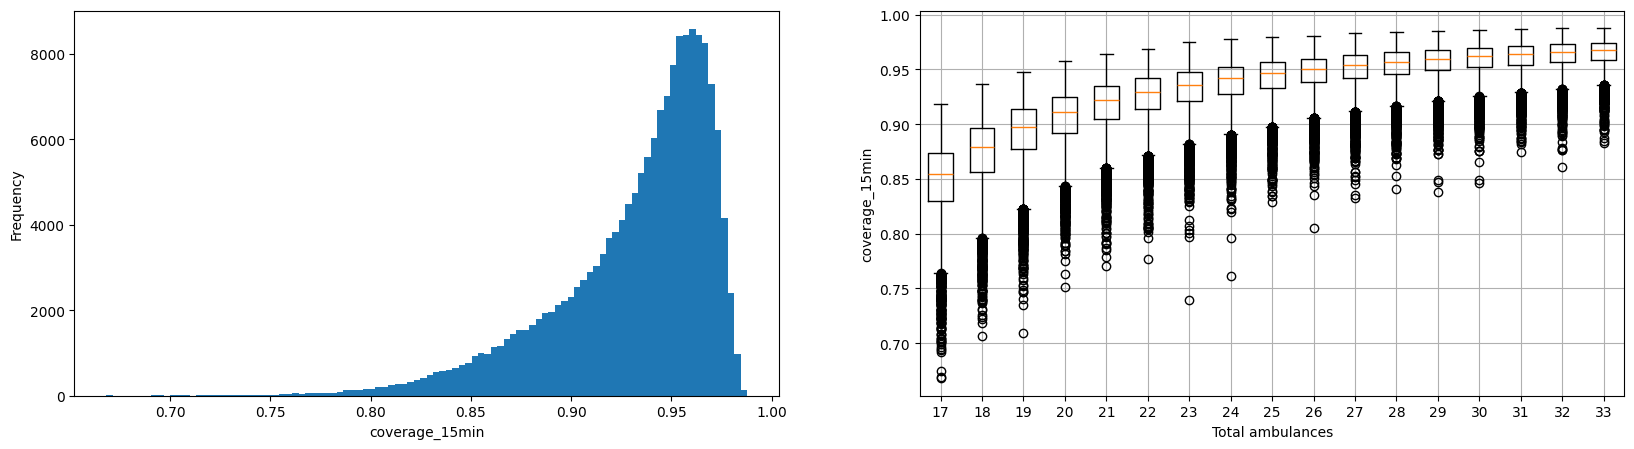

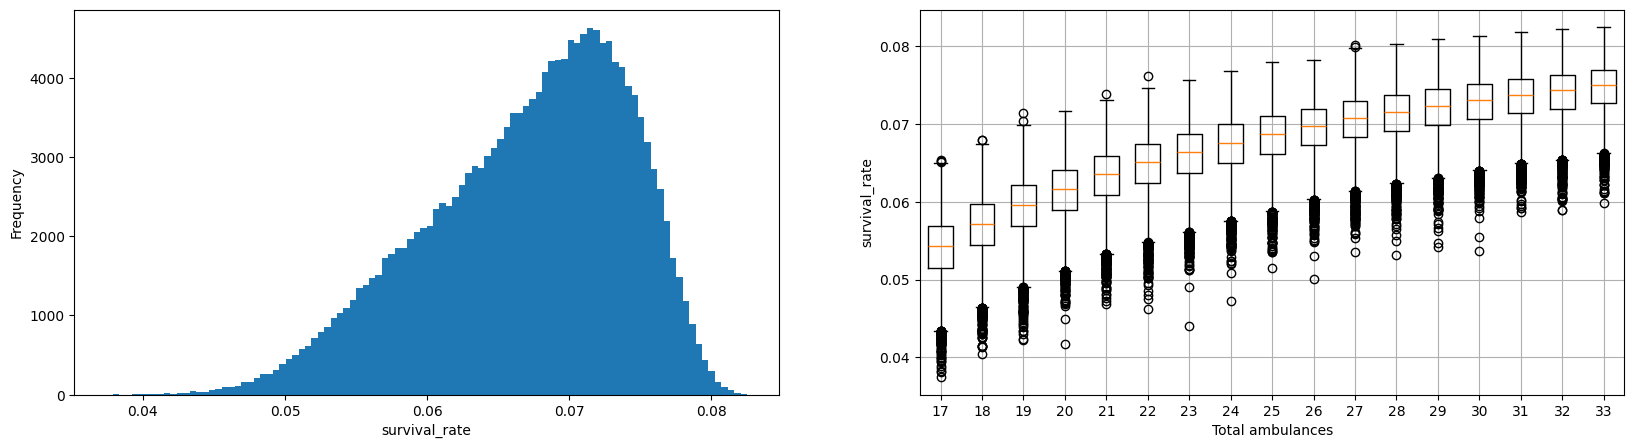

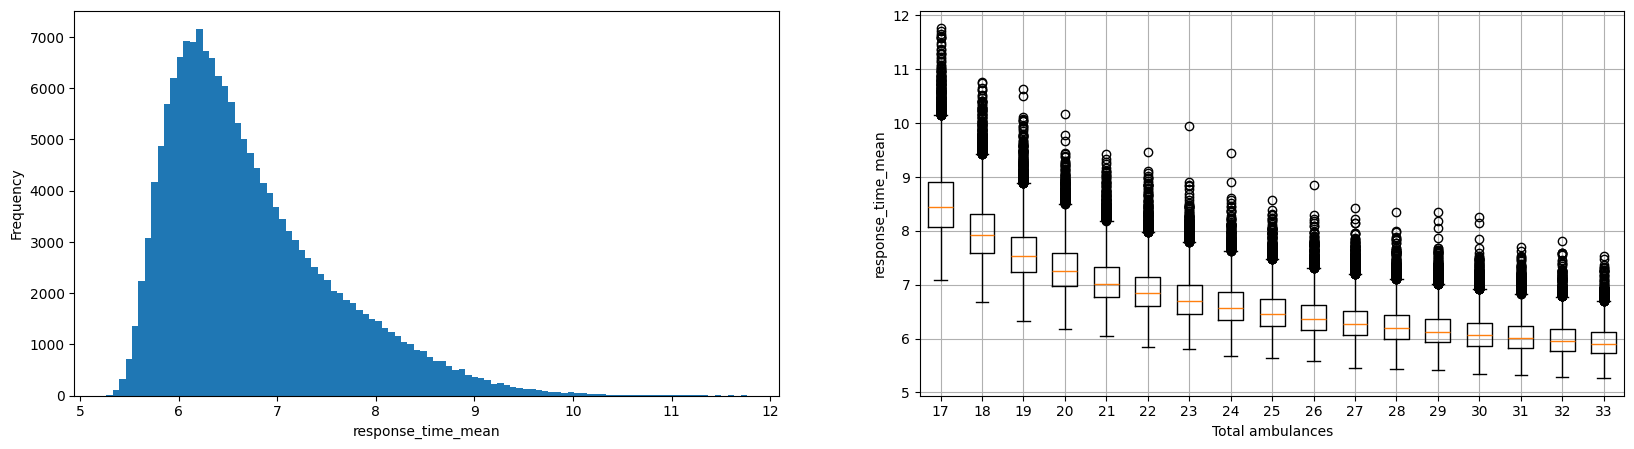

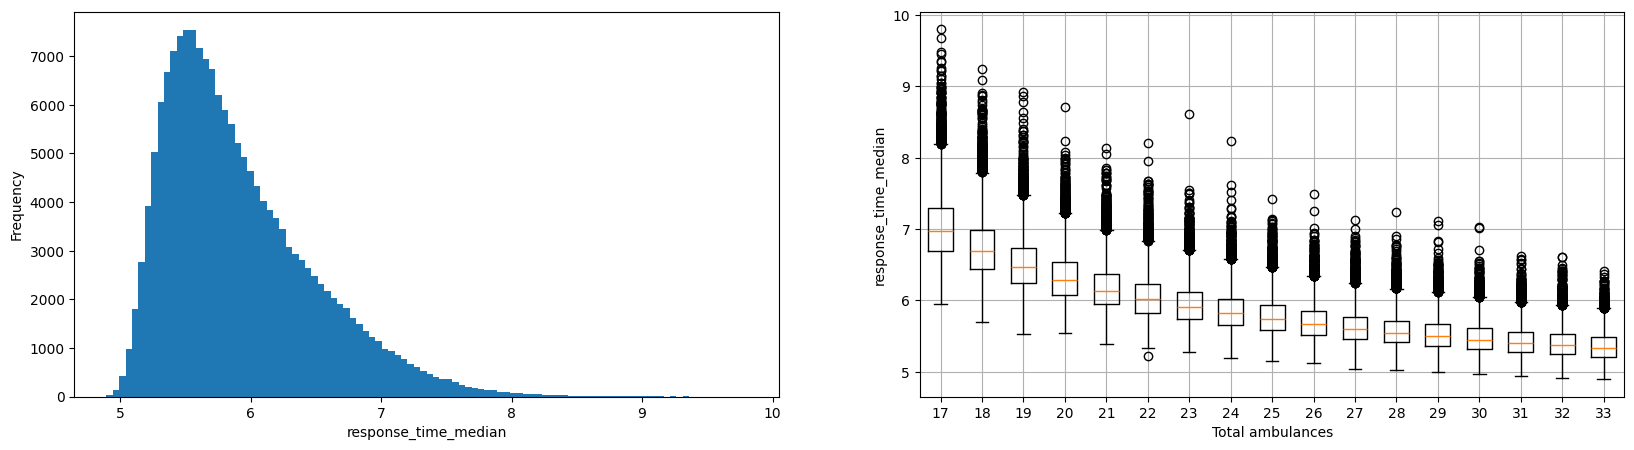

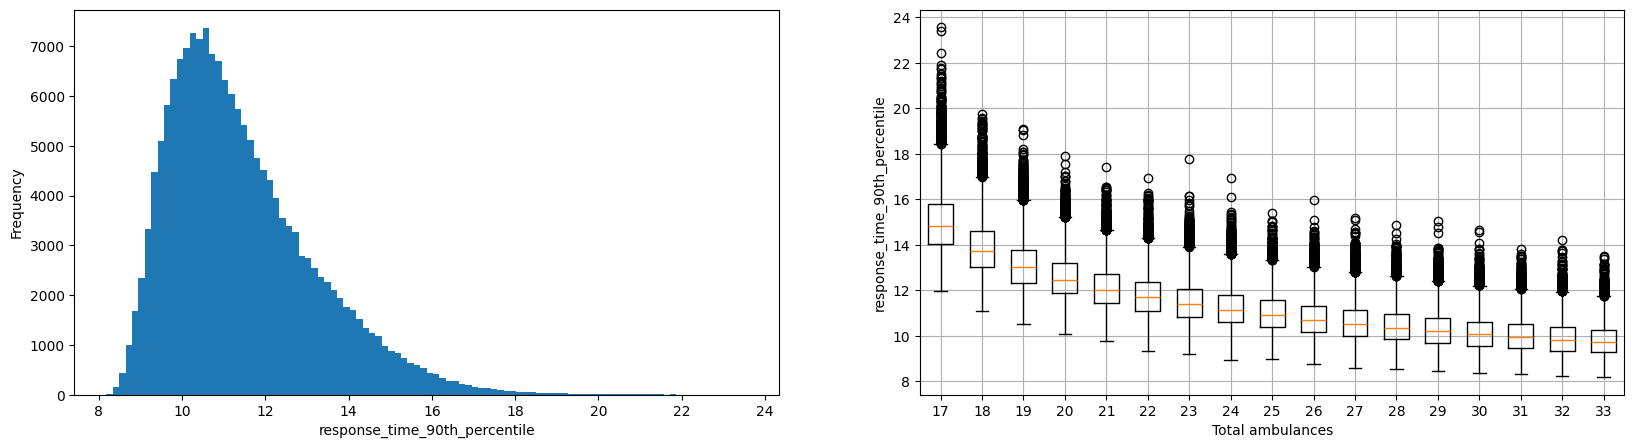

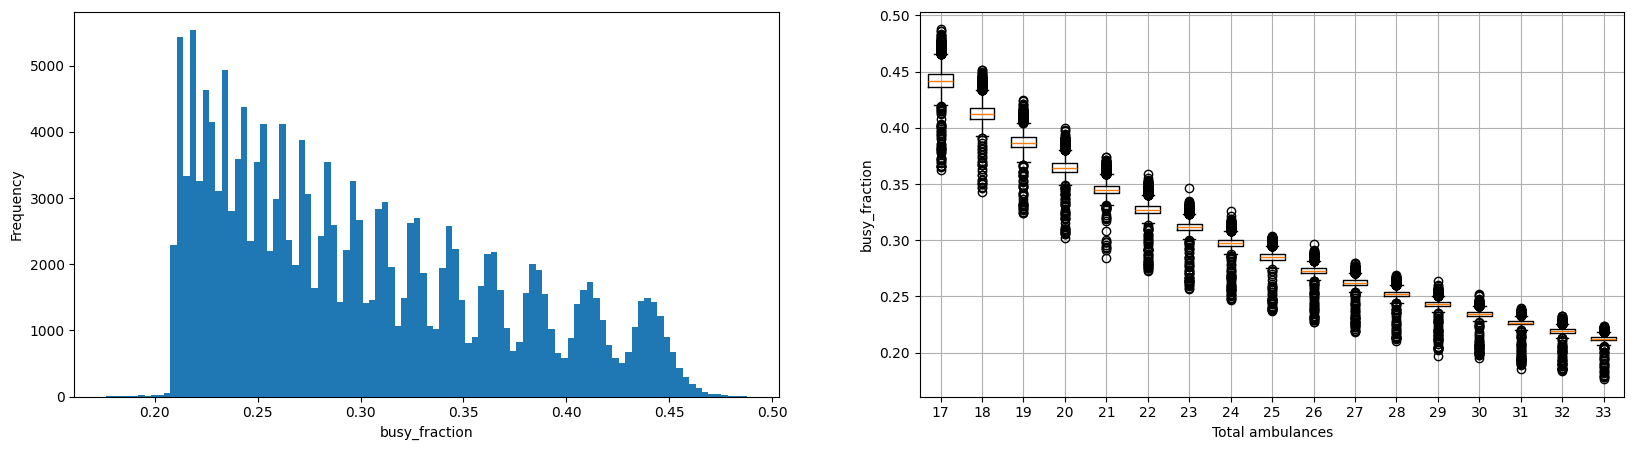

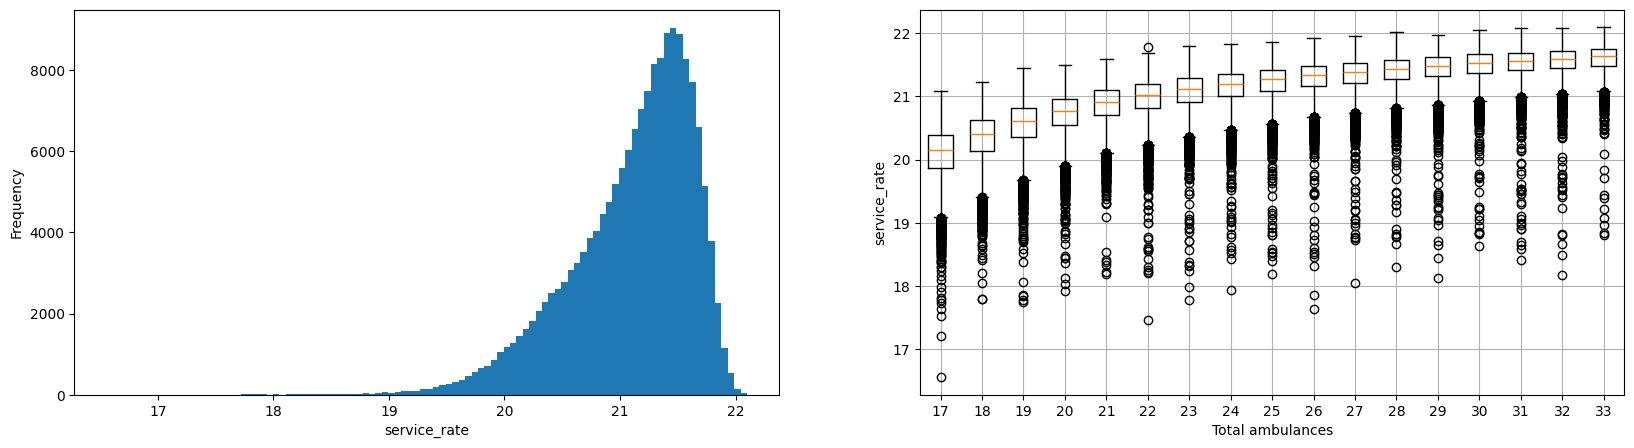

In [2]:
N_AMBULANCES = 25  # 20, 25, 30

region_id = 5
with open('ems_data.pkl', 'rb') as f:
    ems_data = pickle.load(f)
ems_data.region_id = region_id
demand_nodes = EMSData.read_patient_locations(region_id, test_id=0)
n_stations = len(ems_data.stations)
n_demand_nodes = len(demand_nodes)
print(f"# stations: {n_stations}")
print(f"# demand nodes: {n_demand_nodes}")
distance = Simulation.driving_distance(demand_nodes, ems_data.stations)
sim = Simulation(ems_data, n_days=100, n_replications=5)

dataset = pd.read_csv(f'dataset{region_id}.csv')
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()

for metric in METRICS:
    y = Y[:, METRICS.index(metric)]
    plot_metric(X, y, metric)

In [3]:
# Estimate busy_fraction and service_rate
BUSY_FRACTION = {}
SERVICE_RATE = {}
for n_ambulances in [20, 25, 30]:
    # Busy fraction used by MEXCLP so estimate using best w.r.t. coverage_9min
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'coverage_9min')
    BUSY_FRACTION[n_ambulances] = y['busy_fraction']
    # Service rate used by p-median + queueing model so estimate using best w.r.t. response_time_mean
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'response_time_mean')
    SERVICE_RATE[n_ambulances] = y['service_rate']
print(f"BUSY_FRACTION = {BUSY_FRACTION}\nSERVICE_RATE = {SERVICE_RATE}")

BUSY_FRACTION = {20: 0.3565014408893782, 25: 0.2769021029392569, 30: 0.2293679658137418}
SERVICE_RATE = {20: 21.448296831622255, 25: 21.869929046629107, 30: 21.966665014684228}


# Baselines
- Best solutions from the dataset w.r.t `coverage_9min`, `survival_rate`, `response_time_mean`
- MEXCLP
- $p$-Median with queueing

In [4]:
all_results = []  # Columns: ['model_name', 'n_ambulances', *METRICS]

In [5]:
# Best solutions from dataset
for metric in ['coverage_9min', 'survival_rate', 'response_time_mean']:
    x, y = best_solution_from_dataset(dataset, N_AMBULANCES, metric)
    model_name = f'best_{metric}'
    n_ambulances = x.sum()
    new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
    all_results.append(new_row)

In [6]:
# MEXCLP
solution = mexclp(
    n_ambulances=N_AMBULANCES,
    distance=distance,
    threshold=MEXCLP_THRESHOLD_9MIN,
    busy_fraction=BUSY_FRACTION[N_AMBULANCES],
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 849 rows, 21220 columns and 21721 nonzeros
Model fingerprint: 0x59102451
Variable types: 0 continuous, 21220 integer (21200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-17, 9e-04]
  Bounds range     [1e+00, 5e+00]
  RHS range        [3e+01, 3e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 452 rows and 18727 columns
Presolve time: 0.01s
Presolved: 397 rows, 2493 columns, 2973 nonzeros
Variable types: 0 continuous, 2493 integer (2475 binary)
Found heuristic solution: objective 0.2083866

Root relaxation: objective 4.248567e-01, 1254 iterations, 0.01 seconds (0.01 wo

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.749851,0.965285,0.077926,5.748883,5.115343,9.337508,0.276838,21.832546
1,0.744611,0.961844,0.077282,5.830732,5.184430,9.402656,0.277643,21.772237
2,0.744474,0.966181,0.077412,5.766332,5.149855,9.435551,0.277897,21.742115
3,0.742833,0.966310,0.077442,5.787056,5.145100,9.364533,0.277597,21.807078
4,0.747054,0.967960,0.078143,5.730615,5.105529,9.305985,0.277382,21.777092


In [7]:
model_name = 'MEXCLP'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

In [8]:
# p-Median with queuing
solution = pmedian_with_queuing(
    n_ambulances=N_AMBULANCES,
    distance=distance,
    arrival_rate=ems_data.avg_calls_per_day,
    service_rate=SERVICE_RATE[N_AMBULANCES],
    success_prob=SUCCESS_PROB,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17909 rows, 17060 columns and 68200 nonzeros
Model fingerprint: 0x1a04a0b9
Variable types: 16960 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+01]
  Objective range  [2e-04, 9e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve time: 0.04s
Presolved: 17909 rows, 17060 columns, 68200 nonzeros
Variable types: 16960 continuous, 100 integer (100 binary)
Found heuristic solution: objective 17.5277450

Root relaxation: objective 4.148680e+00, 301 iterations, 0.06 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.769727,0.980190,0.079040,5.508740,5.105635,8.630696,0.272563,22.056595
1,0.771400,0.979514,0.079423,5.520622,5.079654,8.676445,0.272102,22.089919
2,0.767913,0.977704,0.079083,5.526531,5.067450,8.665435,0.274519,22.016946
3,0.769768,0.979902,0.079149,5.515838,5.101544,8.606434,0.275127,22.054974
4,0.767291,0.980201,0.079293,5.506477,5.084247,8.625389,0.271922,21.989397


In [9]:
model_name = 'p-Median + Queueing'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

In [10]:
# Results so far
pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_9min,25,0.750602,0.976888,0.077368,5.656613,5.198092,9.018967,0.276902,21.789942
1,best_survival_rate,25,0.748829,0.975546,0.078061,5.639426,5.156770,9.113844,0.277699,21.869929
2,best_response_time_mean,25,0.748829,0.975546,0.078061,5.639426,5.156770,9.113844,0.277699,21.869929
3,MEXCLP,25,0.745764,0.965516,0.077641,5.772724,5.140052,9.369247,0.277472,21.786214
4,p-Median + Queueing,25,0.769220,0.979502,0.079198,5.515642,5.087706,8.640880,0.273247,22.041566


# Coverage

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='coverage_9min (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='coverage_9min (transformed)'>],
       dtype=object))

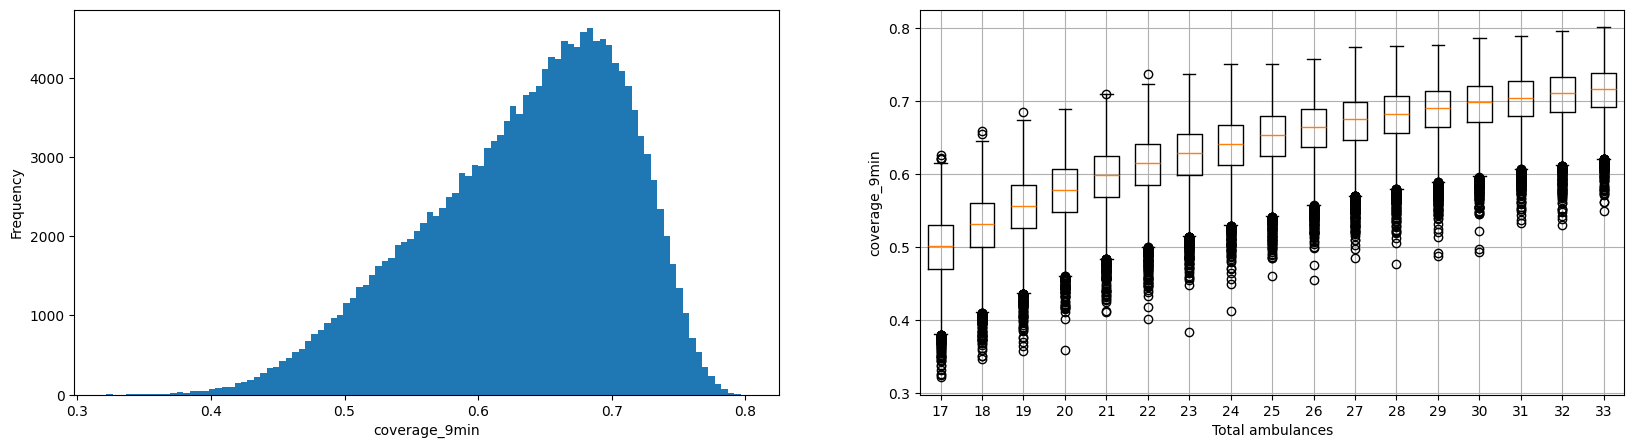

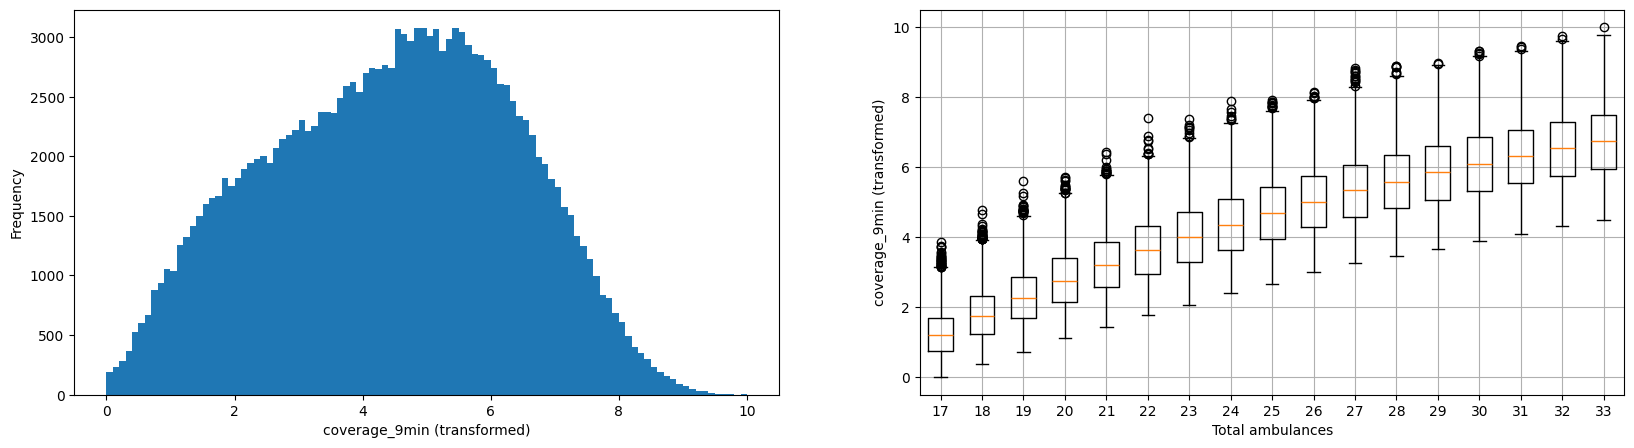

In [11]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'coverage_9min'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='left')
y = scipy.stats.boxcox(y)[0]
# Box-Cox transformation generally turns probabilities into negative values with a small range
# The modified sigmoid function is only nonlinear for positive values
# To deal with negative values and increase the range, we shift and scale
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [12]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    final_hidden_activation=ModifiedSigmoid(),
    name='peel_coverage'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 81%|████████  | 81/100 [04:17<01:00,  3.18s/epoch, best_val_loss=0.0153, train_loss=0.0849, val_loss=0.018] 


Early stopping


 71%|███████   | 71/100 [03:38<01:29,  3.07s/epoch, best_val_loss=0.0043, train_loss=0.0046, val_loss=0.00446]  


Early stopping


 46%|████▌     | 46/100 [02:08<02:31,  2.80s/epoch, best_val_loss=0.0038, train_loss=0.00369, val_loss=0.0038]  

Early stopping


In [13]:
weights, biases = MLP.load_npz('peel_coverage.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3623 rows, 1240 columns and 50862 nonzeros
Model fingerprint: 0x692bad2a
Variable types: 1020 continuous, 220 integer (200 binary)
Coefficient statistics:
  Matrix range     [9e-07, 4e+01]
  Objective range  [6e-02, 1e-01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [7e-03, 4e+01]
Presolve removed 884 rows and 222 columns
Presolve time: 0.09s
Presolved: 2739 rows, 1018 columns, 49096 nonzeros
Variable types: 799 continuous, 219 integer (199 binary)

Root relaxation: objective 1.140370e+01, 471 iterations, 0.02 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.40370 

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.780309,0.977814,0.080414,5.492805,5.015990,8.542557,0.277812,21.927991
1,0.776561,0.975760,0.080151,5.534297,5.039352,8.607677,0.273247,21.911432
2,0.780465,0.974435,0.080447,5.514652,5.048625,8.538412,0.278128,21.933471
3,0.770519,0.974130,0.079172,5.580796,5.068804,8.594996,0.277486,21.942394
4,0.776272,0.977496,0.080045,5.496402,5.043115,8.476841,0.276802,21.953086


In [14]:
model_name = 'MLP-Coverage'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_9min,25,0.750602,0.976888,0.077368,5.656613,5.198092,9.018967,0.276902,21.789942
1,best_survival_rate,25,0.748829,0.975546,0.078061,5.639426,5.156770,9.113844,0.277699,21.869929
2,best_response_time_mean,25,0.748829,0.975546,0.078061,5.639426,5.156770,9.113844,0.277699,21.869929
3,MEXCLP,25,0.745764,0.965516,0.077641,5.772724,5.140052,9.369247,0.277472,21.786214
4,p-Median + Queueing,25,0.769220,0.979502,0.079198,5.515642,5.087706,8.640880,0.273247,22.041566
5,MLP-Coverage,25,0.776825,0.975927,0.080046,5.523790,5.043177,8.552097,0.276695,21.933675


# Survival

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='survival_rate (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='survival_rate (transformed)'>],
       dtype=object))

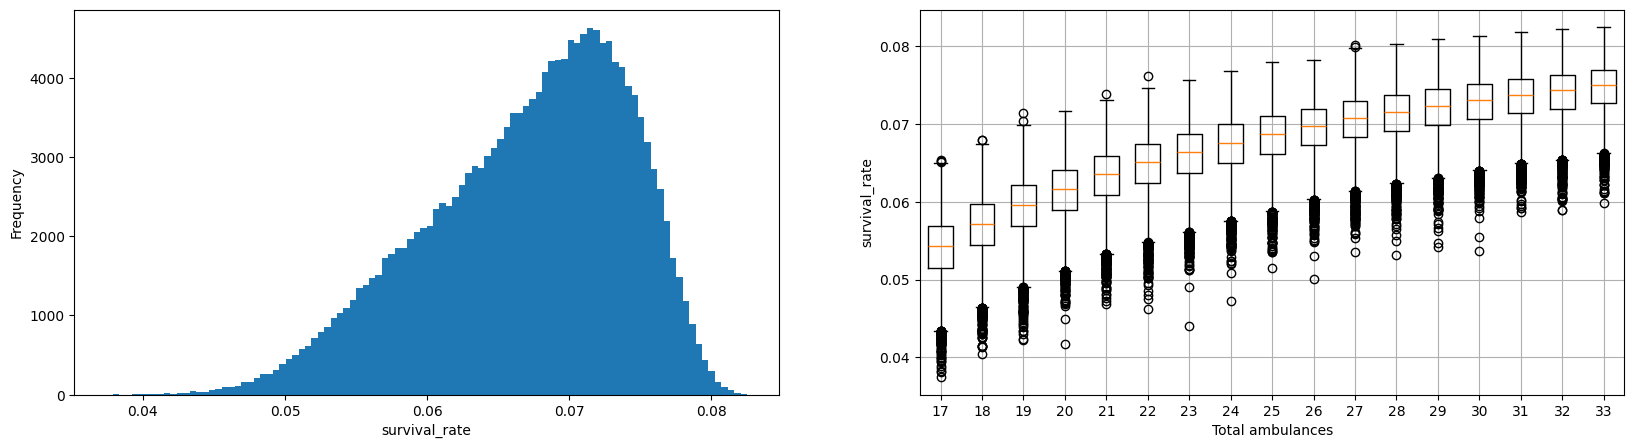

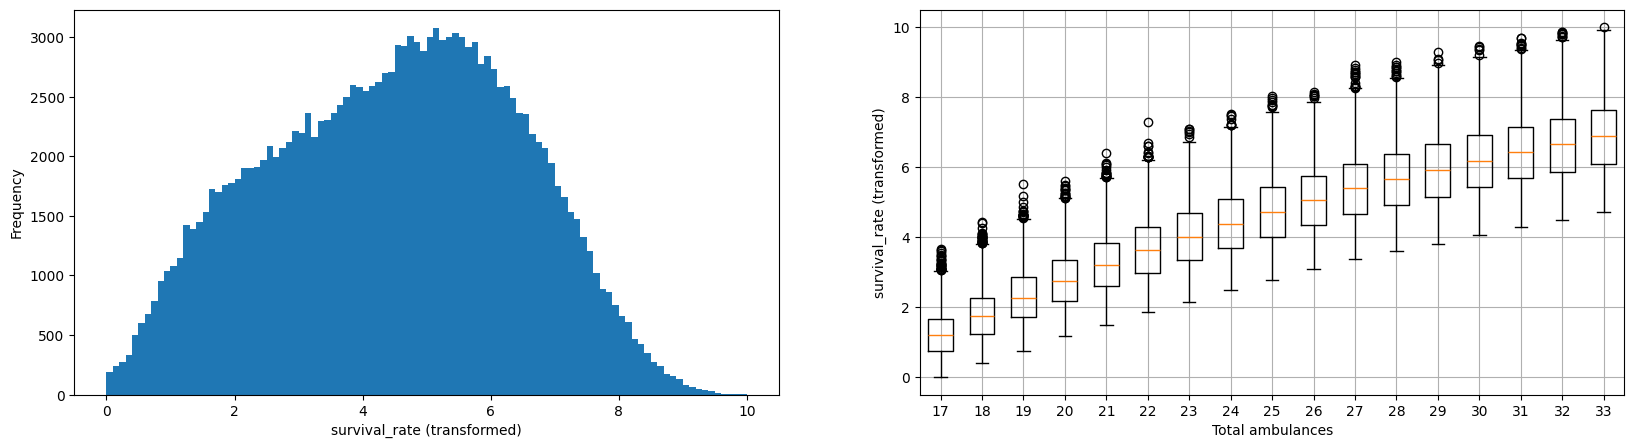

In [15]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'survival_rate'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='left')
y = scipy.stats.boxcox(y)[0]
# Box-Cox transformation generally turns probabilities into negative values with a small range
# The modified sigmoid function is only nonlinear for positive values
# To deal with negative values and increase the range, we shift and scale
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [16]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    final_hidden_activation=ModifiedSigmoid(),
    name='peel_survival'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 60%|██████    | 60/100 [03:17<02:11,  3.30s/epoch, best_val_loss=0.017, train_loss=0.0923, val_loss=0.021] 


Early stopping


 61%|██████    | 61/100 [03:10<02:01,  3.13s/epoch, best_val_loss=0.00447, train_loss=0.00483, val_loss=0.00495]


Early stopping


 25%|██▌       | 25/100 [01:08<03:26,  2.76s/epoch, best_val_loss=0.00382, train_loss=0.00373, val_loss=0.00383]

Early stopping


In [17]:
weights, biases = MLP.load_npz('peel_survival.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3623 rows, 1240 columns and 50862 nonzeros
Model fingerprint: 0x8e6094d5
Variable types: 1020 continuous, 220 integer (200 binary)
Coefficient statistics:
  Matrix range     [3e-06, 3e+01]
  Objective range  [1e-01, 2e-01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [6e-03, 3e+01]
Presolve removed 1206 rows and 222 columns
Presolve time: 0.07s
Presolved: 2417 rows, 1018 columns, 48451 nonzeros
Variable types: 799 continuous, 219 integer (199 binary)

Root relaxation: objective 1.123845e+01, 494 iterations, 0.02 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.23845

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.770662,0.975454,0.079423,5.562651,5.060817,8.737908,0.280227,21.859538
1,0.772367,0.977420,0.080402,5.494945,5.005888,8.619815,0.278250,21.961332
2,0.771304,0.976340,0.079821,5.533985,5.065808,8.647650,0.275980,21.972035
3,0.774088,0.974558,0.079396,5.577417,5.068698,8.782465,0.281292,21.789083
4,0.772169,0.974494,0.080035,5.532797,5.033815,8.725541,0.275091,21.883075


In [18]:
model_name = 'MLP-Survival'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_9min,25,0.750602,0.976888,0.077368,5.656613,5.198092,9.018967,0.276902,21.789942
1,best_survival_rate,25,0.748829,0.975546,0.078061,5.639426,5.156770,9.113844,0.277699,21.869929
2,best_response_time_mean,25,0.748829,0.975546,0.078061,5.639426,5.156770,9.113844,0.277699,21.869929
3,MEXCLP,25,0.745764,0.965516,0.077641,5.772724,5.140052,9.369247,0.277472,21.786214
4,p-Median + Queueing,25,0.769220,0.979502,0.079198,5.515642,5.087706,8.640880,0.273247,22.041566
5,MLP-Coverage,25,0.776825,0.975927,0.080046,5.523790,5.043177,8.552097,0.276695,21.933675
6,MLP-Survival,25,0.772118,0.975653,0.079815,5.540359,5.047005,8.702676,0.278168,21.893012


# p-Median + Queueing

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='response_time_mean (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='response_time_mean (transformed)'>],
       dtype=object))

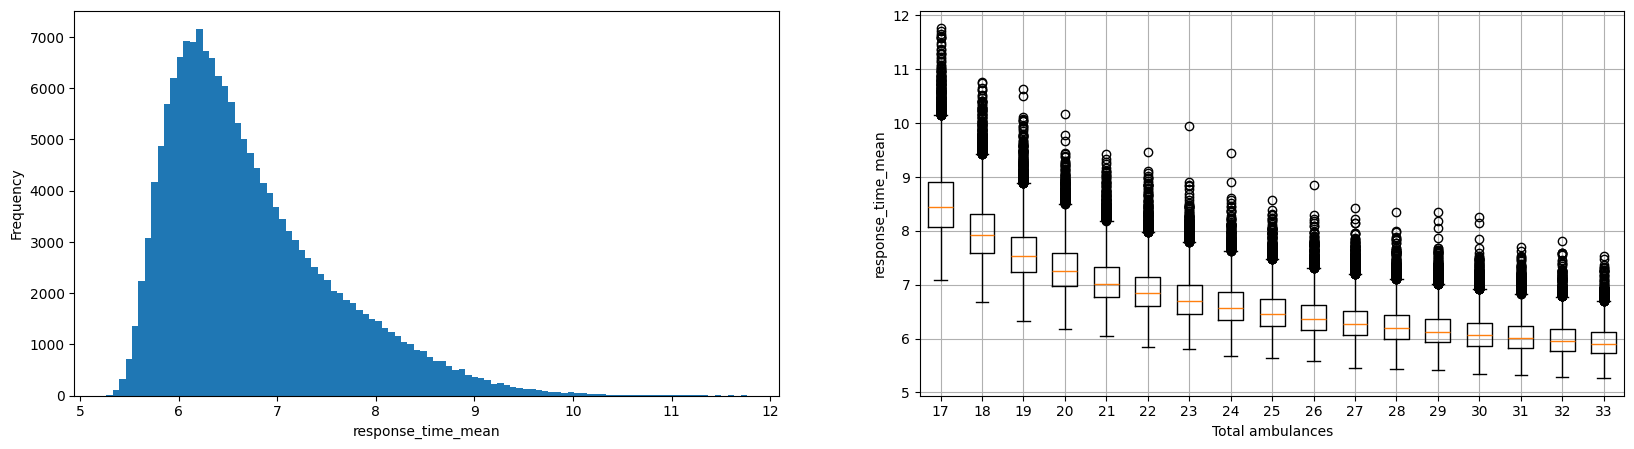

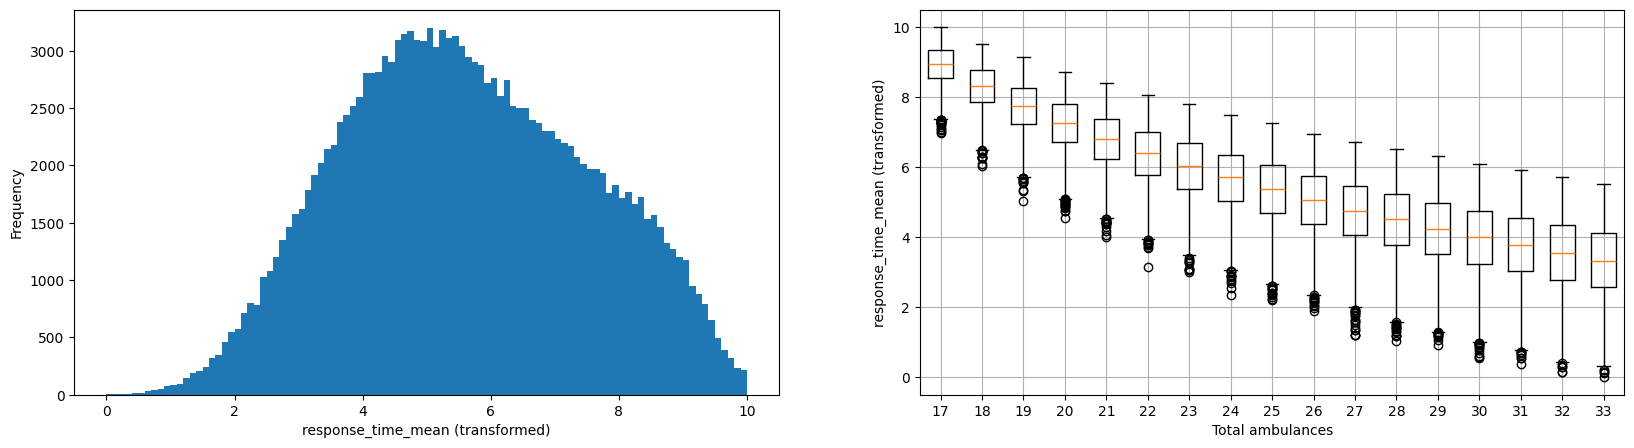

In [19]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'response_time_mean'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='right')
y = scipy.stats.boxcox(y)[0]
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [20]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    name='peel_pmedian'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 25%|██▌       | 25/100 [01:13<03:41,  2.96s/epoch, best_val_loss=0.145, train_loss=0.129, val_loss=0.394]


Early stopping


 74%|███████▍  | 74/100 [03:26<01:12,  2.79s/epoch, best_val_loss=0.00514, train_loss=0.00532, val_loss=0.00563]


Early stopping


 60%|██████    | 60/100 [02:32<01:41,  2.54s/epoch, best_val_loss=0.00388, train_loss=0.00385, val_loss=0.00388]

Early stopping


In [21]:
weights, biases = MLP.load_npz('peel_pmedian.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1621 rows, 1240 columns and 46860 nonzeros
Model fingerprint: 0xbdf4c4d3
Variable types: 1020 continuous, 220 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e-07, 2e+01]
  Objective range  [3e-01, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [4e-04, 3e+01]
Presolve removed 620 rows and 420 columns
Presolve time: 0.06s
Presolved: 1001 rows, 820 columns, 45822 nonzeros
Variable types: 600 continuous, 220 integer (200 binary)
Found heuristic solution: objective 12.5541732
Found heuristic solution: objective 9.6282136

Root relaxation: objective 5.346410e-01, 272 iterations, 0.01 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.775159,0.985462,0.079635,5.450589,5.070004,8.528883,0.273035,22.058390
1,0.777426,0.981693,0.079648,5.441023,5.054300,8.536617,0.269593,22.039197
2,0.773293,0.981695,0.079344,5.491744,5.094169,8.646128,0.276988,21.918613
3,0.761827,0.980228,0.078634,5.541064,5.144083,8.705791,0.277650,22.067669
4,0.771911,0.982246,0.079013,5.487869,5.109296,8.574517,0.273118,22.099412


In [22]:
model_name = 'MLP-pMedian'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_9min,25,0.750602,0.976888,0.077368,5.656613,5.198092,9.018967,0.276902,21.789942
1,best_survival_rate,25,0.748829,0.975546,0.078061,5.639426,5.156770,9.113844,0.277699,21.869929
2,best_response_time_mean,25,0.748829,0.975546,0.078061,5.639426,5.156770,9.113844,0.277699,21.869929
3,MEXCLP,25,0.745764,0.965516,0.077641,5.772724,5.140052,9.369247,0.277472,21.786214
4,p-Median + Queueing,25,0.769220,0.979502,0.079198,5.515642,5.087706,8.640880,0.273247,22.041566
5,MLP-Coverage,25,0.776825,0.975927,0.080046,5.523790,5.043177,8.552097,0.276695,21.933675
6,MLP-Survival,25,0.772118,0.975653,0.079815,5.540359,5.047005,8.702676,0.278168,21.893012
7,MLP-pMedian,25,0.771923,0.982265,0.079255,5.482458,5.094370,8.598387,0.274077,22.036656
